Evaluation and comparison of the distance measure's clustering capabilities for datasets of different perturbation levels, sample sizes and distance metrics

In [1]:
import __init__
from typing import List
import mhn

import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import RandomMHNGenerator as rmg
import ClusterableMhnGenerator as cmg
from definition import EventDistanceMeasurer as edm

c:\Users\michi\Desktop\Uni\Bachelorarbeit\ws24_mbonart_mhn-feature-clustering\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checkpoint directory is: c:\Users\michi\Desktop\Uni\Bachelorarbeit\ws24_mbonart_mhn-feature-clustering\src\mbonart_checkpoints


Add different levels of perturbation on the ground truth MHN generated in 'ground_truth_generation.ipynb' and sample datasets of sizes 1000-100000.

loading from ../mbonart_checkpoints/rmg1/mhn_SET
loading from ../mbonart_checkpoints/rmg1/mhn_TRAINED


(<matplotlib.image.AxesImage at 0x1f373f4b860>,
 <matplotlib.colorbar.Colorbar at 0x1f373fa0260>)

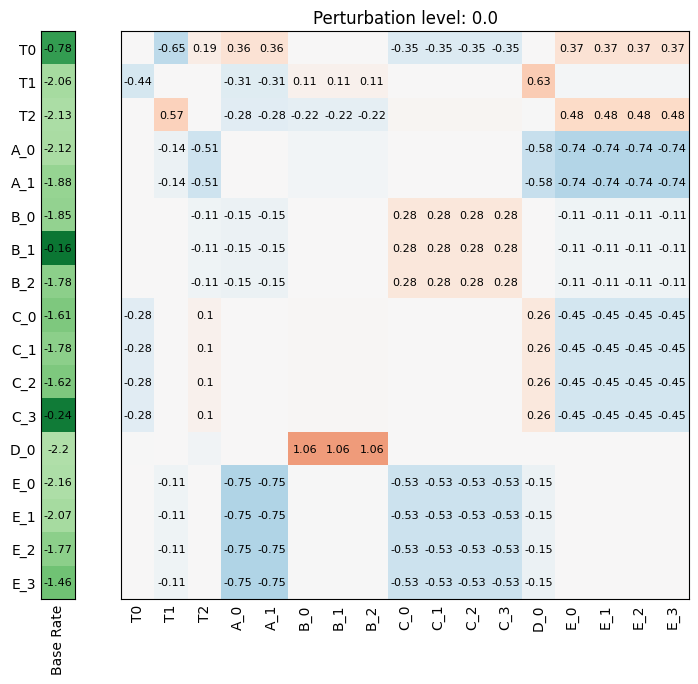

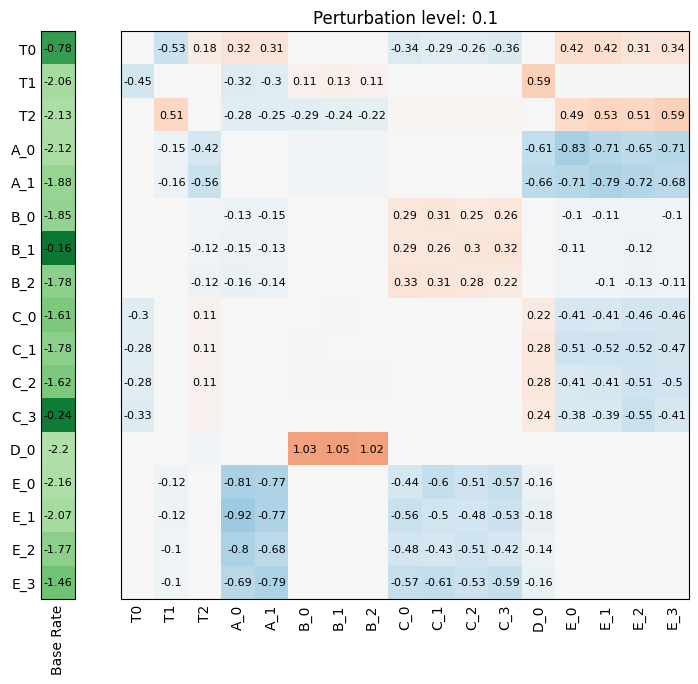

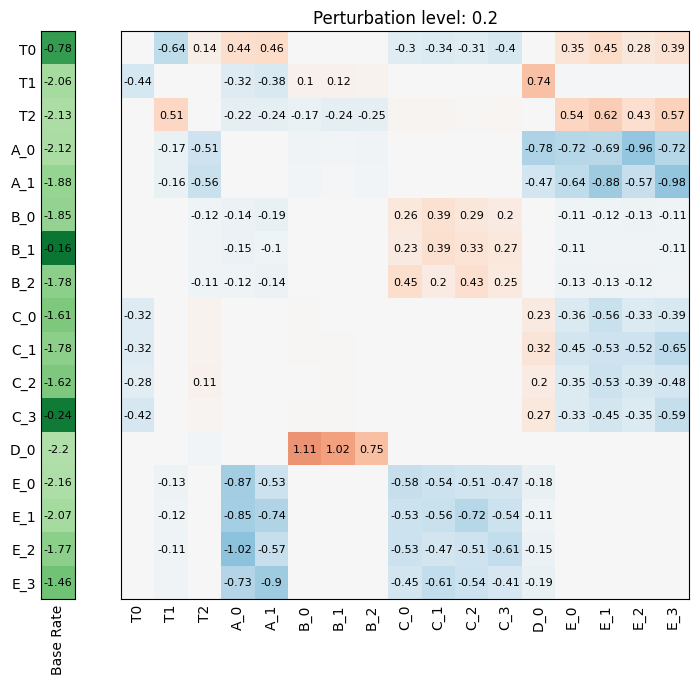

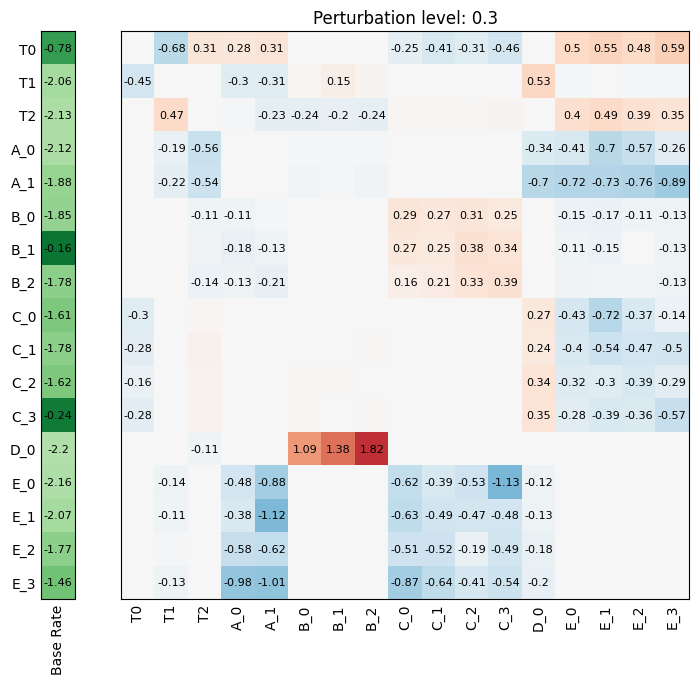

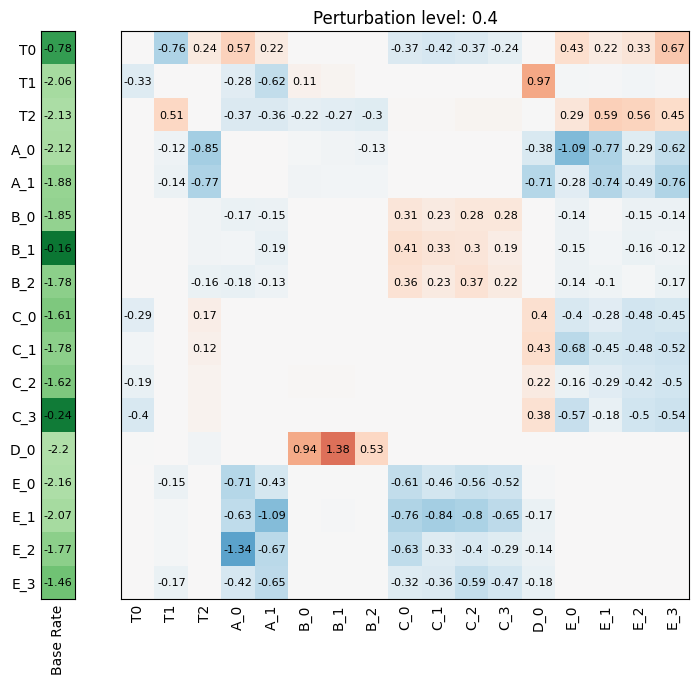

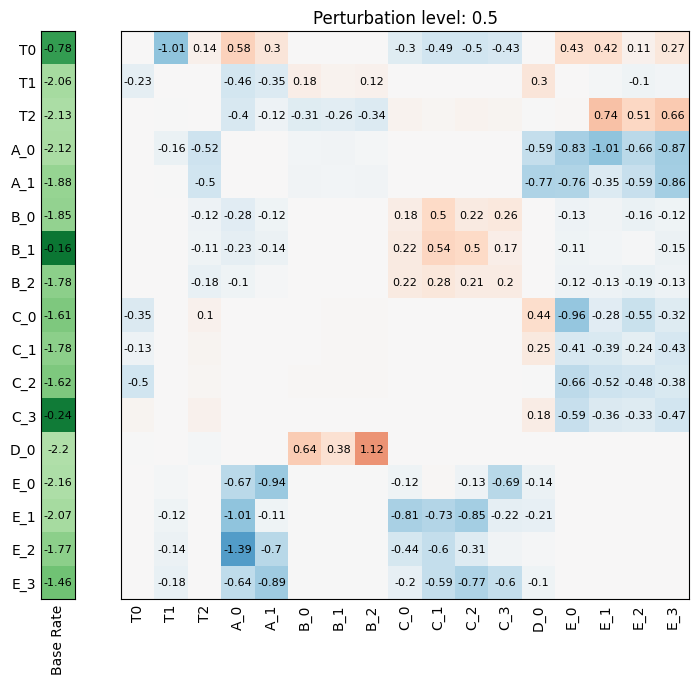

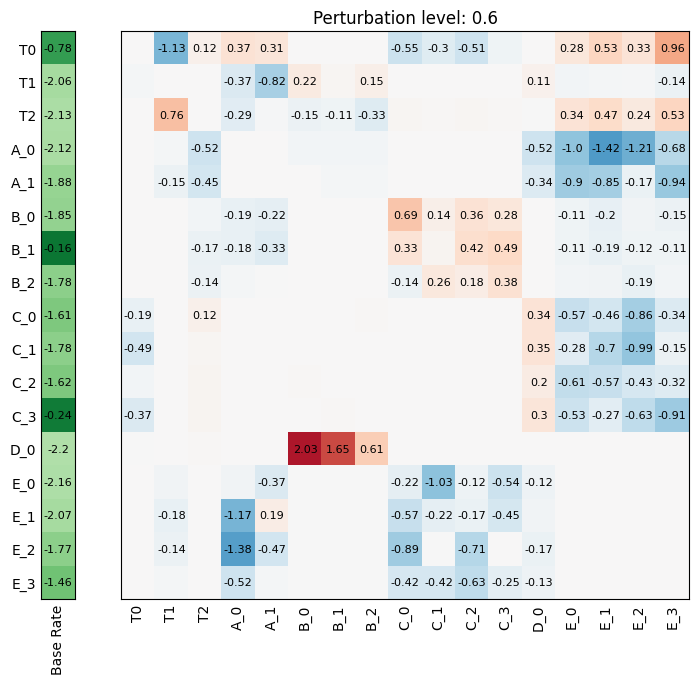

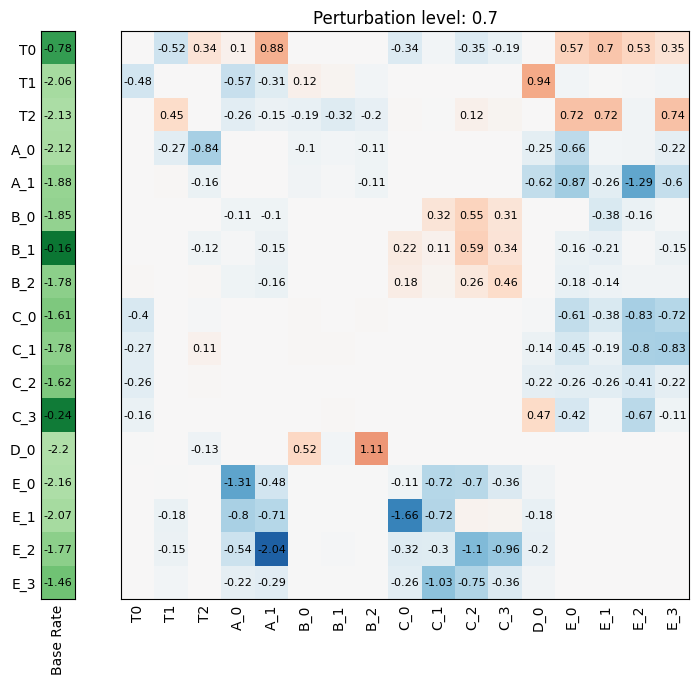

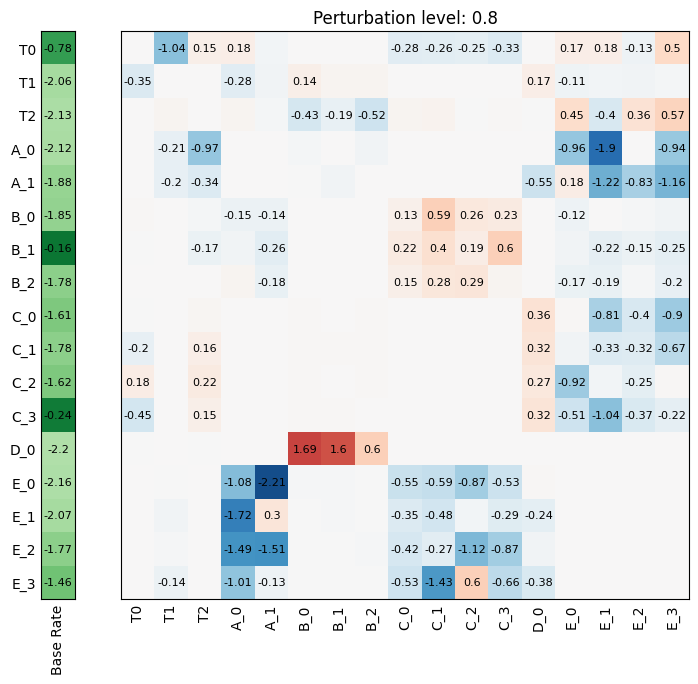

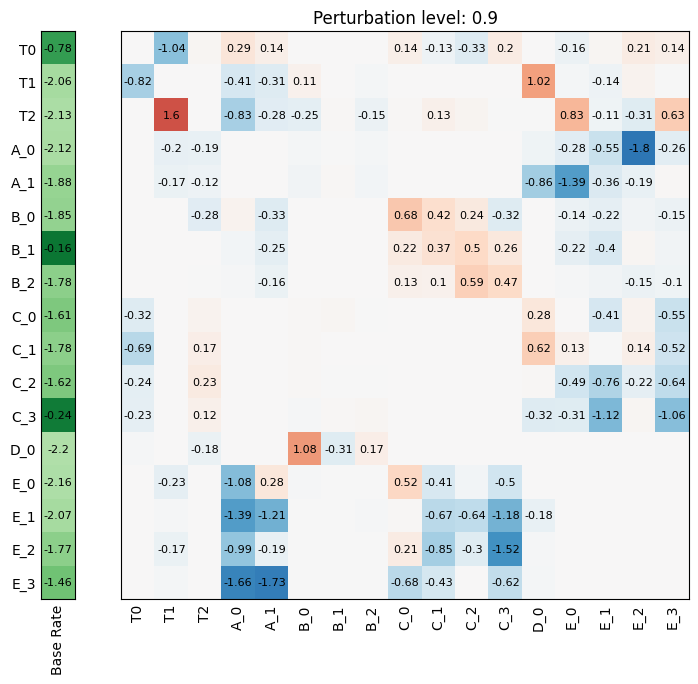

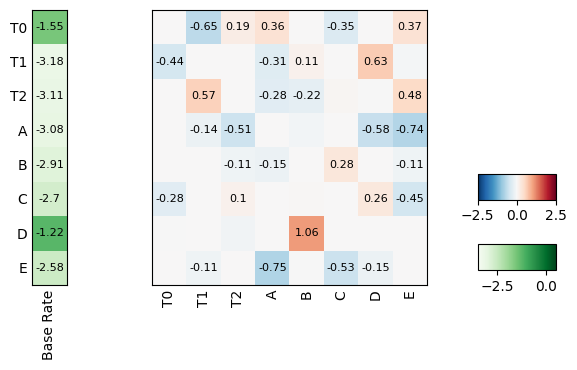

In [2]:
np.random.seed(12345)

cl_generator = cmg.ClusterableMhnGenerator(3,5)
rand_generator = rmg.RandomMHNGenerator(cl_generator.getEvents())
rand_generator.loadfrom("../mbonart_checkpoints/rmg1")
cl_generator.setClusterMHN(rand_generator.getMHN())
given_clustersizes=[2,3,4,1,4]
cl_generator.splitClusters(given_clustersizes)
cl_generator.randomizeBaseRates() 

test_events = cl_generator.getEvents(cmg.DOM.TEST)
events = cl_generator.getEvents(cmg.DOM.CLUSTER)


noise_levels=[i/10 for i in range(10)]
sample_sizes=[1000, 2500, 7500, 20000, 50000, 100000]

np.random.seed(31415)
noisy_mhns: List[mhn.model.cMHN] = [cl_generator.get_noisy_MHN(amplitude= noise_level) for noise_level in noise_levels]

sampled_datas :List[List[pd.DataFrame]]=[]
sampled_datas=[[noisy_mhn.sample_artificial_data(sample_size, as_dataframe=True) for sample_size in sample_sizes] for noisy_mhn in noisy_mhns]
    

for nl, noisy_mhn in zip(noise_levels,noisy_mhns):
    noisy_mhn.plot(colorbar=False)
    plt.title(f"Perturbation level: {nl}")

rand_generator.getMHN().plot()

Train all MHNs used by the EventDistanceMeasurers for each combination of perturbation level and samplesize.

In [3]:
all_dist_measurers:List[List[edm.EventDistanceMeasurer]] = [[edm.getDistMeasurer(sampled_data) for sampled_data in row] for row in sampled_datas]


Directory for storage is edm_0bc8a665f87bb/T0_T1_T2
check if c:\Users\michi\Desktop\Uni\Bachelorarbeit\ws24_mbonart_mhn-feature-clustering\src\mbonart_checkpoints\edm_0bc8a665f87bb\T0_T1_T2   does exist
Directory for storage is edm_a122e7fdede17/T0_T1_T2
check if c:\Users\michi\Desktop\Uni\Bachelorarbeit\ws24_mbonart_mhn-feature-clustering\src\mbonart_checkpoints\edm_a122e7fdede17\T0_T1_T2   does exist
Directory for storage is edm_62c1a65641cae/T0_T1_T2
check if c:\Users\michi\Desktop\Uni\Bachelorarbeit\ws24_mbonart_mhn-feature-clustering\src\mbonart_checkpoints\edm_62c1a65641cae\T0_T1_T2   does exist
Directory for storage is edm_bb8ccb1daf129/T0_T1_T2
check if c:\Users\michi\Desktop\Uni\Bachelorarbeit\ws24_mbonart_mhn-feature-clustering\src\mbonart_checkpoints\edm_bb8ccb1daf129\T0_T1_T2   does exist
Directory for storage is edm_be3c7defd1bac/T0_T1_T2
check if c:\Users\michi\Desktop\Uni\Bachelorarbeit\ws24_mbonart_mhn-feature-clustering\src\mbonart_checkpoints\edm_be3c7defd1bac\T0_T1_T

Compute all distance matrices. Select method to compare $\theta_{T,e}$'s

In [67]:
for row in all_dist_measurers:
    for dist_measurer in row:
        dist_measurer.compute_distance_matrix(edm.DIST.OFFDIAG_L1)

We split the resulting dendograms at different heights. The height can be specified by the number of clusters $n_{cluster}$ we desire. At first we look at the adjusted rand scores, where the correct value of $n_{cluster}=5$ is given, then we explore what is the highest possible adjusted rand score we can get by choosing $n_{cluster} \in \mathbb{N}$

In [68]:
cluster_size_range=range(14)
all_linkages=[[scipy.cluster.hierarchy.linkage(dist_measurer._dist_mat, method="average") for dist_measurer in row] for row in all_dist_measurers]
all_cut_trees=[[[np.concatenate(scipy.cluster.hierarchy.cut_tree(linkage, n_clusters=n_clusters)) for n_clusters in cluster_size_range] for linkage in row] for row in all_linkages]

C:\Users\michi\AppData\Local\Temp\ipykernel_25528\2973254245.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  all_linkages=[[scipy.cluster.hierarchy.linkage(dist_measurer._dist_mat, method="average") for dist_measurer in row] for row in all_dist_measurers]


In [69]:
from sklearn.metrics.cluster import adjusted_rand_score

cluster_solution=np.concatenate([[i]*c_size for i, c_size in enumerate(given_clustersizes)])

all_ar_scores=[[[adjusted_rand_score(cluster_solution,cut_tree) for cut_tree in l] for l in row] for row in all_cut_trees]
all_max_ar_scores=[[np.max(l) for l in row] for row in all_ar_scores]
all_sum_ar_scores=[[np.sum(l) for l in row] for row in all_ar_scores]

Text(50.722222222222214, 0.5, 'Perturbation level')

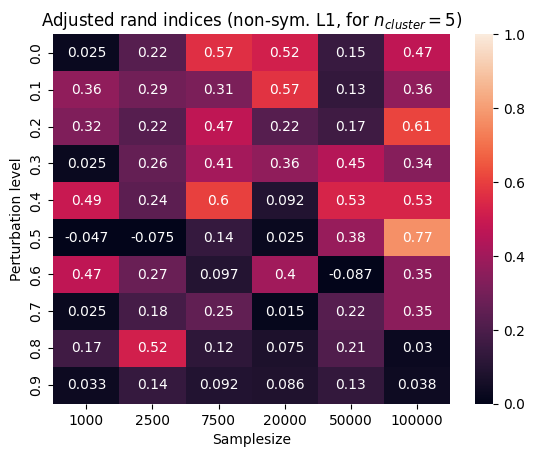

In [70]:
sns.heatmap([[l[5] for l in row] for row in all_ar_scores],vmin=0,vmax=1, xticklabels=sample_sizes, yticklabels=noise_levels, annot=True)
#plt.title("Adjusted rand indices $ARI$ (for $n_{cluster} =5$)")
plt.title("Adjusted rand indices (non-sym. L1, for $n_{cluster} =5$)")
#plt.title("$ARI$ (non-symmetrizing L1-dist) (for $n_{cluster} =5$)")
plt.xlabel("Samplesize")
plt.ylabel("Perturbation level")

<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
C:\Users\michi\AppData\Local\Temp\ipykernel_25528\3306505920.py:3: SyntaxWarning: invalid escape sequence '\i'
  plt.title("Achievable maximum of $ARI$ (for $n_{cluster}\in \mathbb{N}$)")


Text(50.722222222222214, 0.5, 'Perturbation level')

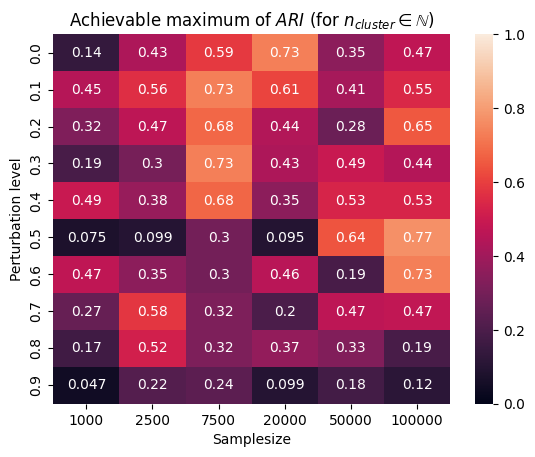

In [71]:
sns.heatmap(all_max_ar_scores,vmin=0,vmax=1, xticklabels=sample_sizes, yticklabels=noise_levels, annot=True)
#plt.title("Achievable maximum of $ARI$  $(\\text{for } n_{cluster}\in \mathbb{N})$")
plt.title("Achievable maximum of $ARI$ (for $n_{cluster}\in \mathbb{N}$)")
#plt.title("maximum $ARI$ (when cutting at any one height level)")
plt.xlabel("Samplesize")
plt.ylabel("Perturbation level")

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\michi\AppData\Local\Temp\ipykernel_25528\2535083948.py:2: SyntaxWarning: invalid escape sequence '\i'
  plt.title("SUM of Adjusted rand scores $(n_{cluster} \in \mathbb{N})$")


Text(50.722222222222214, 0.5, 'Perturbation level')

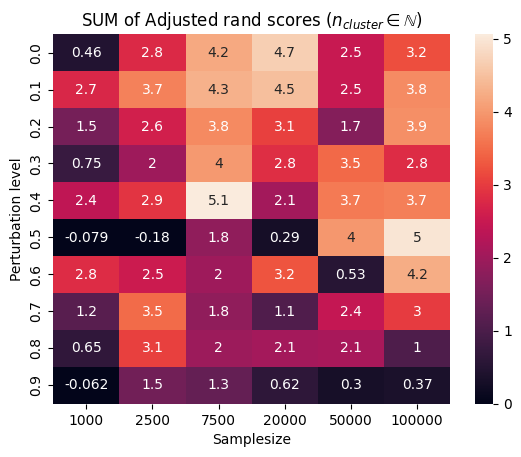

In [72]:
sns.heatmap(all_sum_ar_scores,vmin=0, xticklabels=sample_sizes, yticklabels=noise_levels, annot=True)
plt.title("SUM of Adjusted rand scores $(n_{cluster} \in \mathbb{N})$")
plt.xlabel("Samplesize")
plt.ylabel("Perturbation level")

Display example linkages

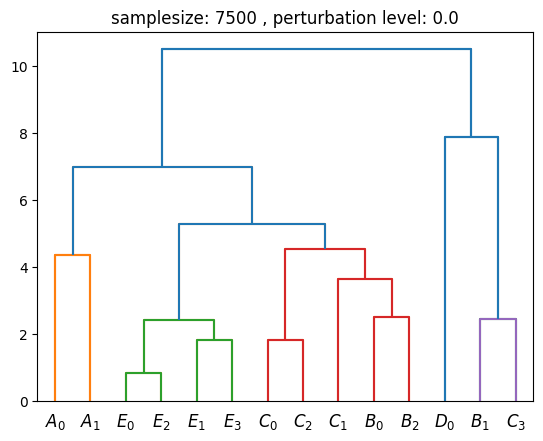

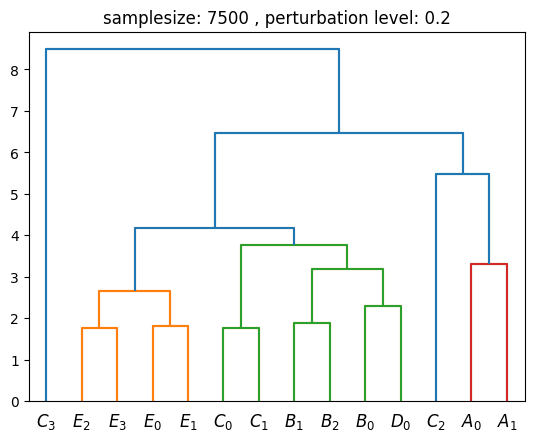

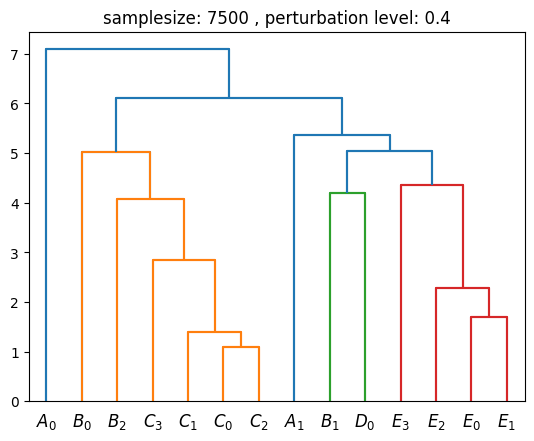

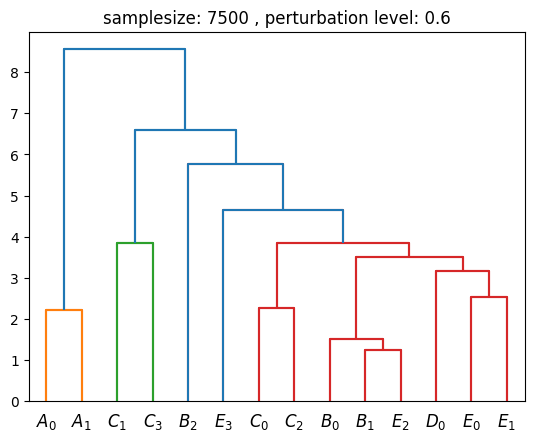

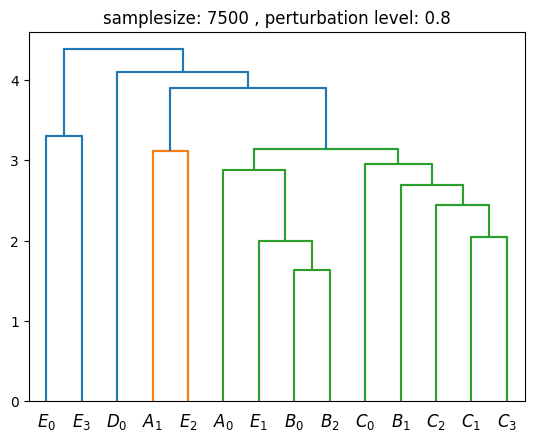

In [ ]:
#select and view hierarchical clustering for selected examples
for nindex in [0,2,4,6,8]:
    ex_linkage=all_linkages[nindex][2]
    dendogram_heights=[y[1] for y in scipy.cluster.hierarchy.dendrogram(ex_linkage)['dcoord']]
    dendogram_heights.sort()
    scipy.cluster.hierarchy.dendrogram(ex_linkage, labels= [f"${ev}$" for ev in events],color_threshold=dendogram_heights[-4])
    plt.title(f"samplesize: {sample_sizes[2]} , perturbation level: {noise_levels[nindex]}")
    plt.show()

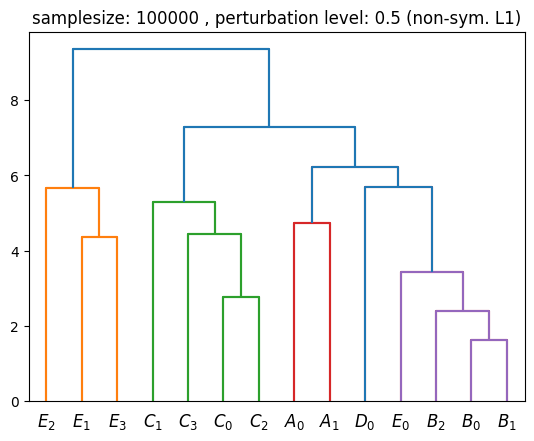

In [ ]:
ex_linkage=all_linkages[5][5]

dendogram_heights=[y[1] for y in scipy.cluster.hierarchy.dendrogram(ex_linkage)['dcoord']]
dendogram_heights.sort()

scipy.cluster.hierarchy.dendrogram(ex_linkage, labels= [f"${ev}$" for ev in events], color_threshold=dendogram_heights[-4])

plt.title(f"samplesize: {sample_sizes[5]} , perturbation level: {noise_levels[5]} (non-sym. L1)")
plt.show()